# <span style="color:#4174B9">Baseball Statistics</span>

Baseball statistics are used in evaluating a player's and/or a team's performance. Since the flow of a baseball game has natural breaks to it, and normally players act individually rather than performing in clusters, the sport lends itself to easy record-keeping and statistics. Statistics have been kept for professional baseball since the creation of the National League and American League, now part of Major League Baseball. The following analysis is based on baseball data made available by Sean Lahman, an award-winning database journalist and author. The data can be downloaded from his [website](http://www.seanlahman.com/baseball-archive/statistics/).

The importance of statistics in baseball increased with the advent of free agency in 1974. Statistics beacame vital information in determining individual salary, with the free agent market clearly setting what each player should be paid for his given statistics. Let us examine if the individual salary set by this market comply with the teams objective.

## <span style="color:#117A65">Analysis of MLB payrolls</span>

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import seaborn as sns

# Set display properties
%pylab inline
sns.set_style('white')
pd.options.display.max_rows = 8
pd.options.display.max_columns = 15

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read data from csv file into pandas dataframe
def read_csv(filename):
    # The argument to this function is the filename of csv file
    path = './baseballdatabank-master/core/'
    data = pd.read_csv(path + filename, sep=',', keep_default_na=False, na_values=[''])
    print filename, 'has', data.shape[0], 'rows and', data.shape[1], 'columns'
    return data

In [3]:
# Format summary statistics of salary
def salary_stats(s):
    # The argument to this function is a pandas series
    stats = s.describe().iloc[1:].apply(lambda x: '$%1.3fM' % (x*1e-6))
    return stats

In [4]:
# Read in the salary details
salaries = read_csv('Salaries.csv')

Salaries.csv has 25575 rows and 5 columns


In [5]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 5 columns):
yearID      25575 non-null int64
teamID      25575 non-null object
lgID        25575 non-null object
playerID    25575 non-null object
salary      25575 non-null int64
dtypes: int64(2), object(3)
memory usage: 999.1+ KB


In [6]:
print salaries.head(), '\n'
print 'Data from', salaries.yearID.min(), 'to', salaries.yearID.max()

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000 

Data from 1985 to 2015


The data contains the salary information of each player for a given year along with their team affiliation. The dataset at hand has data from 1985-2015. Let us look at the variation in salaries with time.

### <span style="color:#2471A3">Variation in player salary with time</span>

In [7]:
# Average annual salary of a player
yearly_avg_salary = salaries.groupby('yearID').mean()['salary']
salary_stats(yearly_avg_salary)

mean    $1.979M
std     $1.225M
min     $0.417M
25%     $0.971M
50%     $1.993M
75%     $3.039M
max     $4.301M
Name: salary, dtype: object

In [8]:
# Format salary labels to make them concise in plots
def millions(x, pos):
    # The two args are the value and tick position
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

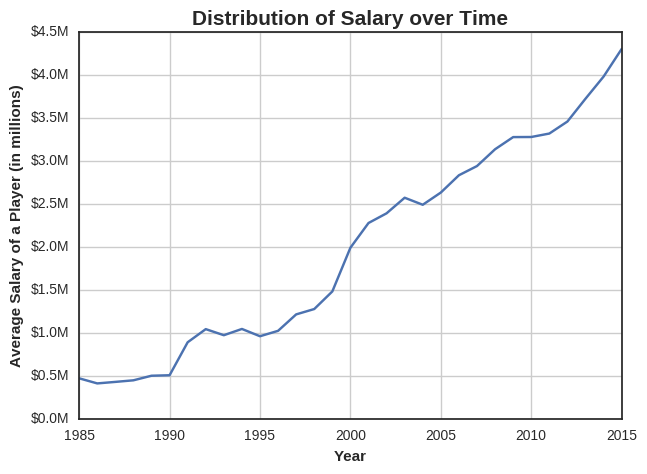

In [9]:
# Plot average annual salary vs year
f, ax = plt.subplots()
f.set_size_inches((7,5))

ax.yaxis.set_major_formatter(formatter)
plt.plot(yearly_avg_salary.index, yearly_avg_salary)

plt.title("Distribution of Salary over Time", fontsize=15, weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("Average Salary of a Player (in millions)", weight='bold')

plt.grid()

In [10]:
inc = (yearly_avg_salary[2015] - yearly_avg_salary[1985]) / yearly_avg_salary[1985]
print 'Increase in salary since 1985 as compared to 2015 is about {0}%'.format(inc*100)

Increase in salary since 1985 as compared to 2015 is about 800%


The average yearly salary of a baseball player has an increasing trend with time. Since 1985, it has increased by about 800%. The average salary of a MLB player in 1985 was about five hundred thousand US dollars as compared to  about two million US dollars in 2015.

The period 1993-95 is an exception to this trend. This may be attributed to the [1994–95 Major League Baseball strike](https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike). Also, the year 2004 has a dip which may be attributed to the announcement of [new drug policy](https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_players_suspended_for_performance-enhancing_drugs) in Jan 2004 which led to suspension of many MLB players for the use of performance-enhancing drugs. Let us look at the distribution of salaries across teams.

### <span style="color:#2471A3">Distribution of Salary across Teams</span>

In [11]:
# Average team salary
yearly_payroll = salaries.groupby(['teamID', 'yearID'], as_index=False).sum()
yearly_avg_payroll = yearly_payroll.groupby('teamID').mean()['salary']
yearly_avg_payroll

teamID
ANA    5.851150e+07
ARI    7.065607e+07
ATL    6.305574e+07
BAL    5.629822e+07
           ...     
TBA    4.625734e+07
TEX    5.851075e+07
TOR    5.431831e+07
WAS    7.917704e+07
Name: salary, dtype: float64

In [12]:
salary_stats(yearly_avg_payroll)

mean     $57.764M
std      $21.405M
min      $17.973M
25%      $45.354M
50%      $58.511M
75%      $65.027M
max     $118.607M
Name: salary, dtype: object

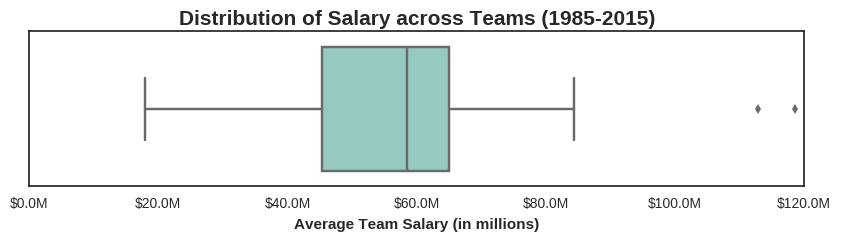

In [13]:
# Boxplot of average team salary
plt.figure(figsize=(10,2))

g = sns.boxplot(yearly_avg_payroll, palette='Set3')

g.xaxis.set_major_formatter(formatter)
g.set_title("Distribution of Salary across Teams (1985-2015)", fontsize=15, weight='bold')
g.set_xlabel("Average Team Salary (in millions)", weight='bold')

The boxplot reflects the distribution of average payroll amounts of about 150 teams over a period of 30 years. The average payroll amount of a MLB team in this period is about $USD 58 million. It also shows skewness in the data towards higher payroll amounts. Since the plotted data is spread over a wide timeframe, this comparision of teams is misleading. Some teams might be active only in a certain period of this timeframe. In order to account for this and compare contemporary teams, we split the 30 year timeframe into 5-year periods.

In [14]:
def time_periods(year):
    if year <= 1990:
        return '1985-90'
    elif year <= 1995:
        return '1991-95'
    elif year <= 2000:
        return '1996-00'
    elif year <= 2005:
        return '2001-05'
    elif year <= 2010:
        return '2006-10'
    else:
        return '2011-15'

In [15]:
salaries['period'] = salaries.yearID.apply(time_periods)

In [16]:
# Average team salary in 5 year periods
payroll_across_periods = salaries.groupby(['teamID', 'period', 'yearID'], as_index=False).sum()
avg_payroll_across_periods = payroll_across_periods.groupby(['teamID', 'period'], 
                                                            as_index=False).mean().drop(['yearID'], axis=1)
print avg_payroll_across_periods

    teamID   period        salary
0      ANA  1996-00  4.481720e+07
1      ANA  2001-05  7.220579e+07
2      ARI  1996-00  6.069294e+07
3      ARI  2001-05  8.013398e+07
..     ...      ...           ...
175    TOR  2011-15  9.735552e+07
176    WAS  2001-05  4.858150e+07
177    WAS  2006-10  5.527590e+07
178    WAS  2011-15  1.091973e+08

[179 rows x 3 columns]


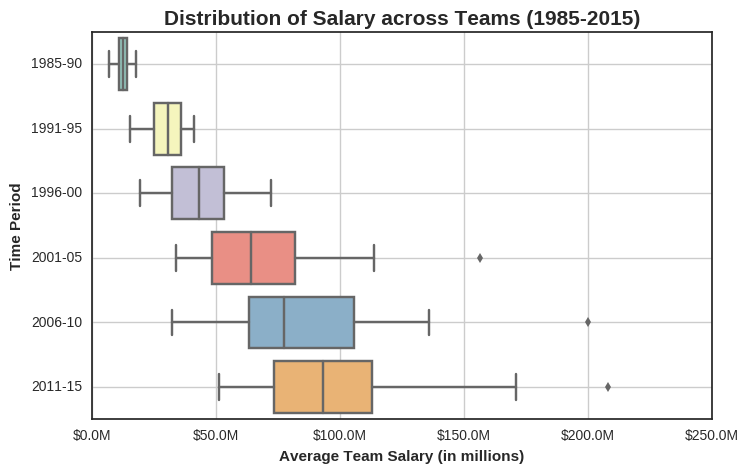

In [17]:
# Boxplot of average team salary across 5-year periods from 1985-2015
plt.figure(figsize=(8,5))

order = ['1985-90', '1991-95', '1996-00', '2001-05', '2006-10', '2011-15']
g = sns.boxplot(x=avg_payroll_across_periods.salary, y=avg_payroll_across_periods.period, palette='Set3',
                order=order)

g.xaxis.set_major_formatter(formatter)
g.set_title("Distribution of Salary across Teams (1985-2015)", fontsize=15, weight='bold')
g.set_xlabel("Average Team Salary (in millions)", weight='bold')
g.set_ylabel("Time Period", weight='bold')

g.grid()

This provides a better visual for comparision of team salaries over time. The above boxplot reflects the widening gap among teams in terms of payroll amounts.

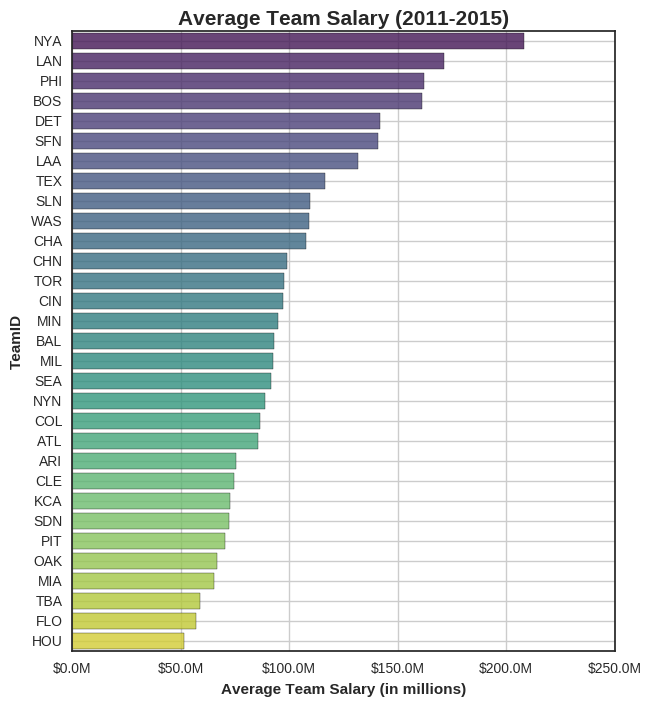

In [18]:
# Barplot of average team salary in the recent years
d = avg_payroll_across_periods[avg_payroll_across_periods.period == '2011-15'].sort_values(ascending=False,
                                                                                           by='salary')
plt.figure(figsize=(7,8))

g = sns.barplot(x=d.salary, y=d.teamID, palette="viridis", alpha=0.8)

g.xaxis.set_major_formatter(formatter)
g.set_title("Average Team Salary (2011-2015)", fontsize=15, weight='bold')
g.set_xlabel("Average Team Salary (in millions)", weight='bold')
g.set_ylabel("TeamID", weight='bold')

g.grid()

In [19]:
salary_stats(avg_payroll_across_periods[avg_payroll_across_periods['period'] == '2011-15'].salary)

mean    $101.622M
std      $37.341M
min      $51.322M
25%      $73.622M
50%      $93.102M
75%     $112.926M
max     $208.214M
Name: salary, dtype: object

In the recent period of 2011-15 the Houston Astros (HOU) had the minimum payroll amount of 51 million US dollars as compared to the payroll amount of 208 million US dollars of New York Yankees (NYA).

Let us analyze the impact of team payrolls on winning percentages of the teams.

In [20]:
# Read in team details
teams = read_csv('Teams.csv')

Teams.csv has 2805 rows and 48 columns


In [21]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 48 columns):
yearID            2805 non-null int64
lgID              2805 non-null object
teamID            2805 non-null object
franchID          2805 non-null object
divID             1288 non-null object
Rank              2805 non-null int64
G                 2805 non-null int64
Ghome             2406 non-null float64
W                 2805 non-null int64
L                 2805 non-null int64
DivWin            1260 non-null object
WCWin             624 non-null object
LgWin             2777 non-null object
WSWin             2448 non-null object
R                 2805 non-null int64
AB                2805 non-null int64
H                 2805 non-null int64
2B                2805 non-null int64
3B                2805 non-null int64
HR                2805 non-null int64
BB                2805 non-null int64
SO                2685 non-null float64
SB                2661 non-null float64
CS    

In [22]:
teams['period'] = teams.yearID.apply(time_periods)
teams['W%'] = (teams.W / teams.G) * 100

In [23]:
# Average team wins vs salaries
avg_wins_across_periods = teams.groupby(['teamID', 'period'], as_index=False).mean()
wins_vs_salary = pd.merge(avg_wins_across_periods, avg_payroll_across_periods,
                          on=['teamID', 'period'])[['teamID','period','W','salary','W%']]
print wins_vs_salary

    teamID   period          W        salary         W%
0      ANA  1996-00  80.250000  4.481720e+07  49.537037
1      ANA  2001-05  85.750000  7.220579e+07  52.932099
2      ARI  1996-00  83.333333  6.069294e+07  51.440329
3      ARI  2001-05  80.400000  8.013398e+07  49.629630
..     ...      ...        ...           ...        ...
175    TOR  2011-15  80.800000  9.735552e+07  49.876543
176    WAS  2001-05  81.000000  4.858150e+07  50.000000
177    WAS  2006-10  66.200000  5.527590e+07  40.909439
178    WAS  2011-15  88.600000  1.091973e+08  54.752703

[179 rows x 5 columns]


In [24]:
def salary_vs_wins(period):
    d = wins_vs_salary[wins_vs_salary.period == period]
    g = sns.jointplot(data=d, x='salary', y='W%', color='#34495e', \
                      kind='reg', marginal_kws=dict(kde=True))
    g.fig.suptitle("Salaries and Wins (" + period + ')', weight='bold', fontsize=12)
    g.set_axis_labels("Salary (in millions)","%Wins", weight='bold')
    g.fig.set_size_inches((6,5))
    g.ax_marg_x.xaxis.set_major_formatter(formatter)
    g.fig.tight_layout()

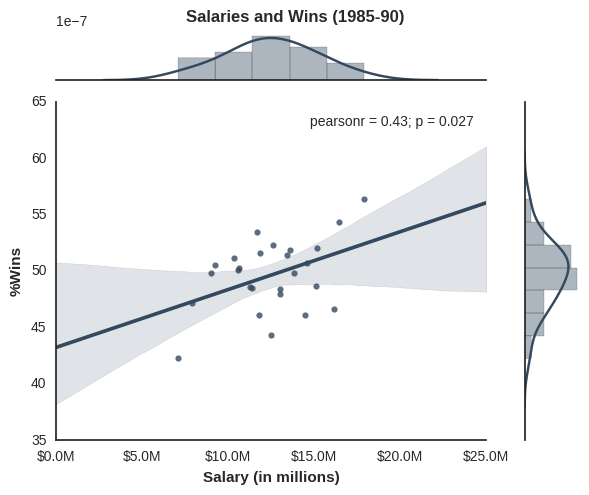

In [25]:
salary_vs_wins(order[0])

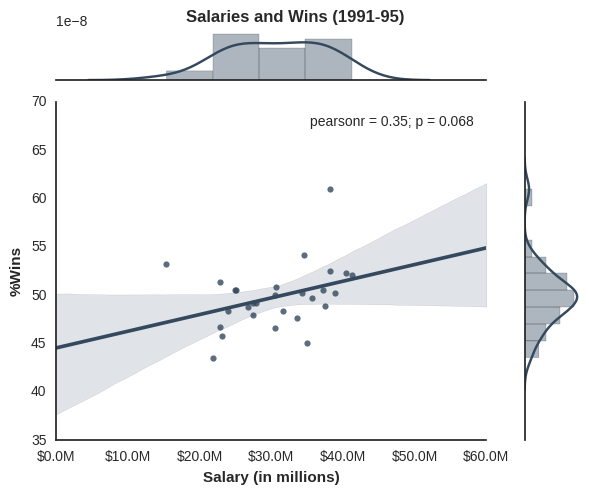

In [26]:
salary_vs_wins(order[1])

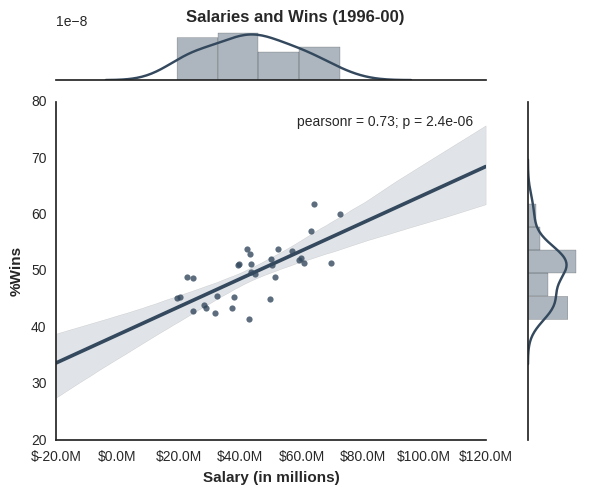

In [27]:
salary_vs_wins(order[2])

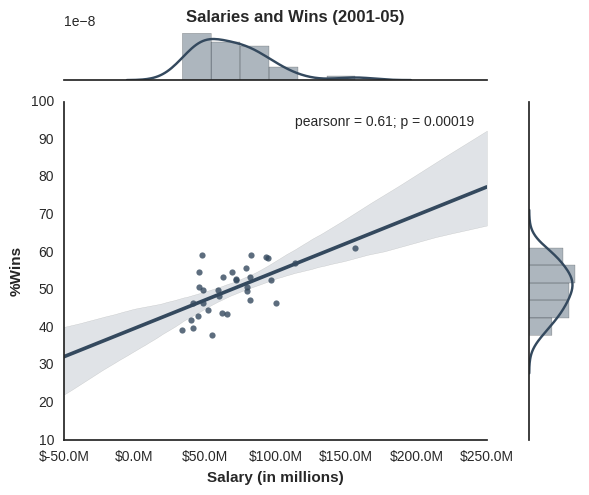

In [28]:
salary_vs_wins(order[3])

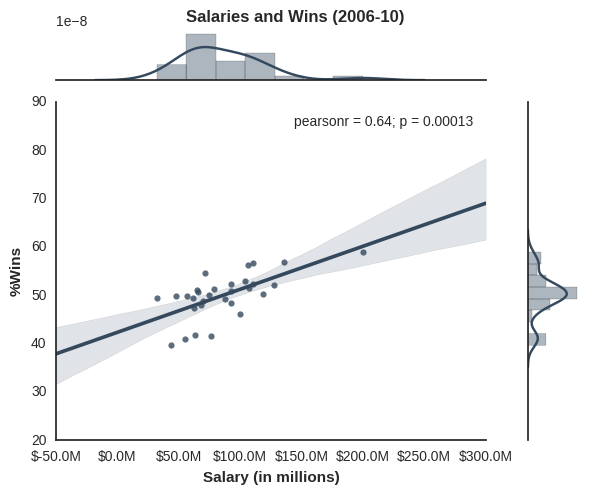

In [29]:
salary_vs_wins(order[4])

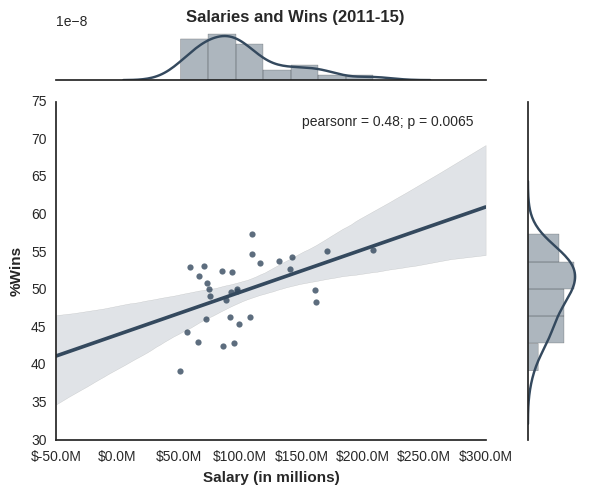

In [30]:
salary_vs_wins(order[5])

### <span style="color:#2471A3">Distribution of Salary across Players</span>

In [31]:
players_avg_salary = salaries.groupby('playerID').mean()['salary']
salary_stats(players_avg_salary)

mean     $1.150M
std      $1.771M
min      $0.060M
25%      $0.253M
50%      $0.497M
75%      $1.175M
max     $22.000M
Name: salary, dtype: object

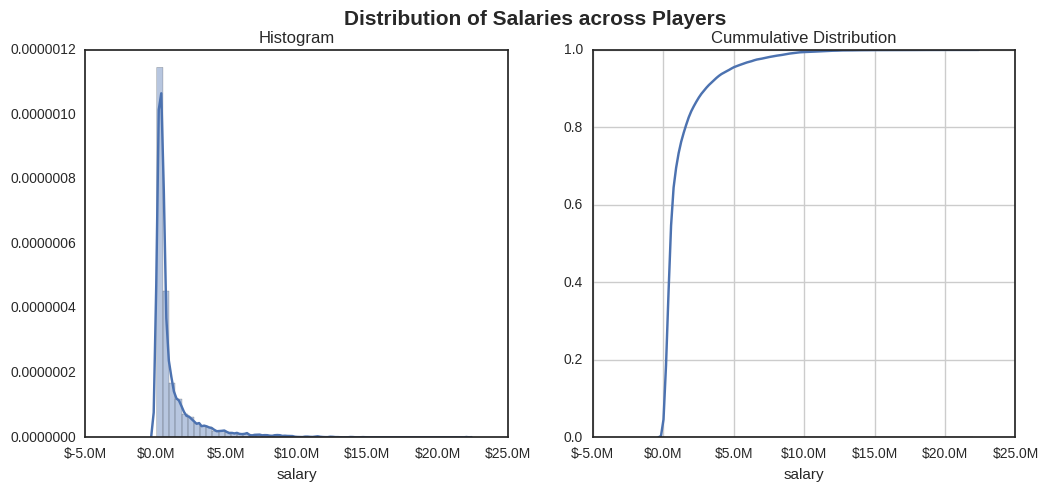

In [33]:
f, ax = plt.subplots(nrows=1, ncols=2)
f.set_size_inches((12,5))
f.suptitle("Distribution of Salaries across Players", fontsize=15, weight='bold')

p1 = sns.distplot(players_avg_salary, ax=ax[0])
p1.xaxis.set_major_formatter(formatter)
p1.set_title("Histogram")

p2 = sns.distplot(players_avg_salary, kde_kws=dict(cumulative=True), ax=ax[1])
p2.xaxis.set_major_formatter(formatter)
p2.set_title("Cummulative Distribution")
p2.grid()

In [34]:
players_avg_salary.skew()

3.4974712434125386

There is an obvious skew in the player salaries due to all-star players with astronomical salaries. This leads to the question - What qualities differentiate all-star players?

To answer this question, we have to compare the player metrics with salaries. For ease, I have split the analysis into two sections - Offense (Batting), Defense (Fielding and Pitching).

In [35]:
batting = read_csv('Batting.csv')
pitching = read_csv('Pitching.csv')
fielding = read_csv('Fielding.csv')

Batting.csv has 101332 rows and 22 columns
Pitching.csv has 44139 rows and 30 columns
Fielding.csv has 170526 rows and 18 columns


In [36]:
# Add salary information to player metrics
batting = batting.merge(salaries[['playerID','salary']], on='playerID', how='left')
pitching = pitching.merge(salaries[['playerID','salary']], on='playerID', how='left')
fielding = fielding.merge(salaries[['playerID','salary']], on='playerID', how='left')

In [37]:
def draw_clustermap(df, fmt=None):
    # Remove ordinal columns
    non_ordinal_cols = [col for col in df.columns if col not in ['yearID', 'Rank']]

    # Compute the correlation matrix
    corr = df[non_ordinal_cols].corr()
    
    # Draw a clustermap using correlation as a distance metric
    g = sns.clustermap(corr, cmap='Spectral', linewidths=.5, metric='correlation', annot=(fmt!=None), fmt=fmt)
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

### <span style="color:#2471A3">Offense metrics</span>

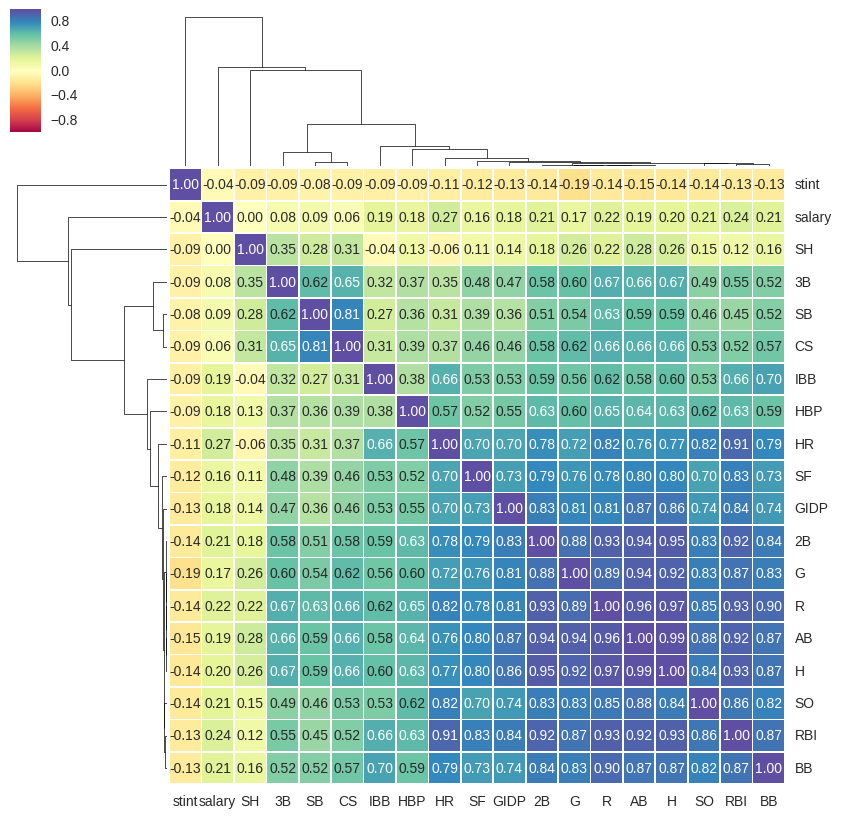

In [38]:
# Correlation clustermap of batting metrics
draw_clustermap(batting, '.2f')

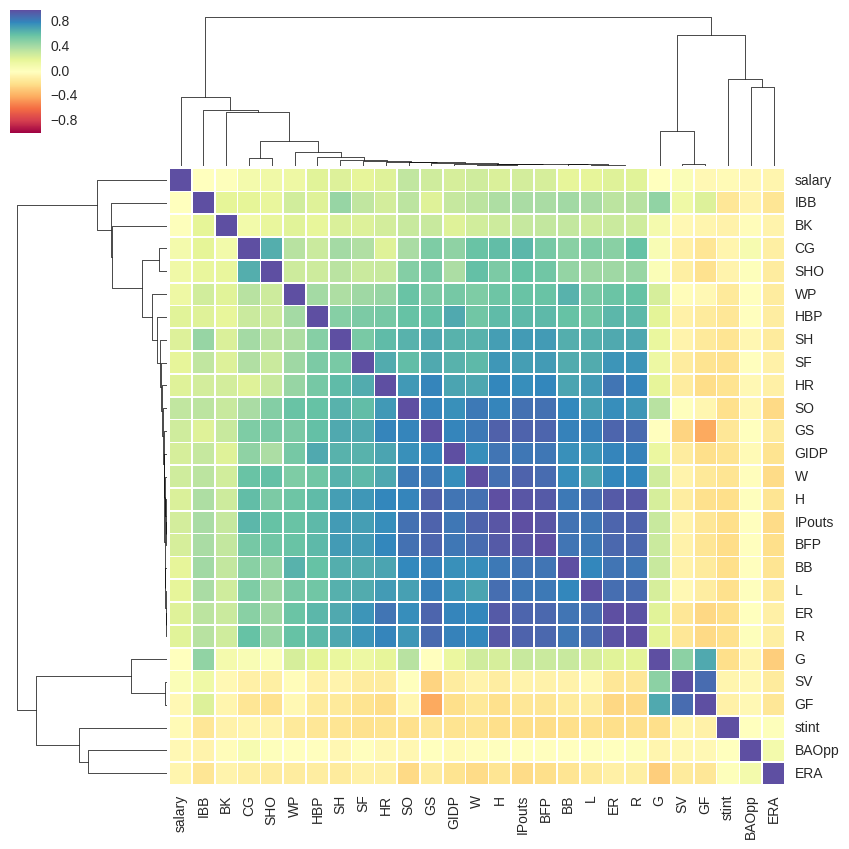

In [39]:
# Correlation clustermap of pitching metrics
draw_clustermap(pitching)

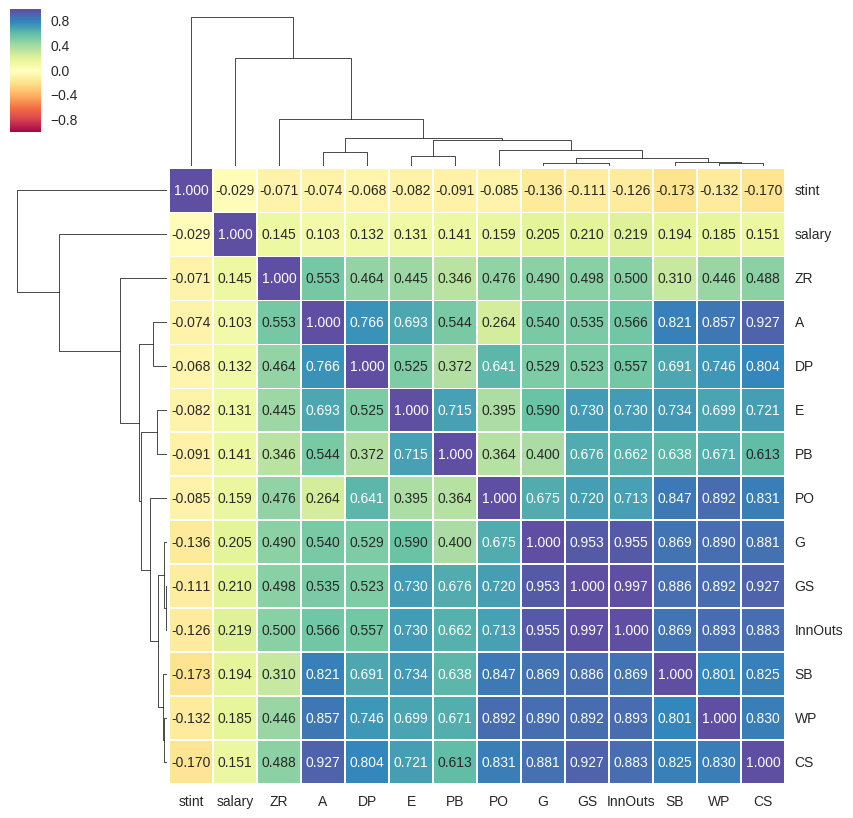

In [40]:
# Correlation clustermap of fielding statistics
draw_clustermap(fielding, '.3f')

## <span style="color:#117A65">Modelling Wins</span>